# Finding RNAfish spots in 256x256 images using Unet, Conv2d

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit
from PIL import Image
import random
import utils

In [2]:
data='/media/smc/YeastEM/'

# Get data

Load data from file

In [3]:
shp=[1,256,256,5]

In [4]:
both=utils.get_raw_float_image(data+'TrainingWindows.tif_RotShift.raw',shp)

train_data=both[0:11590,:,:,[0,1,2]]/255.0
train_truth=both[0:11590,:,:,[3,4]]
train_truth[:,:,:,0]=train_truth[:,:,:,0]/255.0
train_truth[:,:,:,1]=train_truth[:,:,:,1]/255.0

validation_data=both[11590:12810,:,:,[0,1,2]]/255.0
validation_truth=both[11590:12810,:,:,[3,4]]
validation_truth[:,:,:,0]=validation_truth[:,:,:,0]/255.0
validation_truth[:,:,:,1]=validation_truth[:,:,:,1]/255.0

train_both=0

# Design network

Define a function to create a convolutional layer, including conv, relu, maxpool, that can be called multiple times

In [5]:
tf.reset_default_graph()
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, 256,256,3], name='x')
y=tf.placeholder(dtype=tf.float32, shape=[None, 256,256,2], name='y')
lr=tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate')

xr=x
yr=y

base_scaler=64

#Going down
A1=utils.leaky_relu(tf.layers.conv2d(xr, base_scaler, [5,5], padding='SAME'))
A2=utils.leaky_relu(tf.layers.conv2d(A1, base_scaler, [3,3], padding='SAME'))

B0=tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
B1=utils.leaky_relu(tf.layers.conv2d(B0, 2*base_scaler, [3,3], padding='SAME'))
B2=utils.leaky_relu(tf.layers.conv2d(B1, 2*base_scaler, [3,3], padding='SAME'))

C0=tf.nn.max_pool(B2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
C1=utils.leaky_relu(tf.layers.conv2d(C0, 4*base_scaler, [3,3], padding='SAME'))
C2=utils.leaky_relu(tf.layers.conv2d(C1, 4*base_scaler, [3,3], padding='SAME'))

D0=tf.nn.max_pool(C2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
D1=utils.leaky_relu(tf.layers.conv2d(D0, 8*base_scaler, [3,3], padding='SAME'))
D2=utils.leaky_relu(tf.layers.conv2d(D1, 8*base_scaler, [3,3], padding='SAME'))

E0=tf.nn.max_pool(D2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
E1=utils.leaky_relu(tf.layers.conv2d(E0, 16*base_scaler, [3,3], padding='SAME'))
E2=utils.leaky_relu(tf.layers.conv2d(E1, 16*base_scaler, [3,3], padding='SAME'))

#Coming up
DD0=tf.layers.conv2d_transpose(E2, 8*base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
DD1=tf.concat(axis=3, values=[DD0,D2])
DD2=utils.leaky_relu(tf.layers.conv2d(DD1, 8*base_scaler, [3,3], padding='SAME'))
DD3=utils.leaky_relu(tf.layers.conv2d(DD2, 8*base_scaler, [3,3], padding='SAME'))

CC0=tf.layers.conv2d_transpose(DD3, 4*base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
CC1=tf.concat(axis=3, values=[CC0,C2])
CC2=utils.leaky_relu(tf.layers.conv2d(CC1, 4*base_scaler, [3,3], padding='SAME'))
CC3=utils.leaky_relu(tf.layers.conv2d(CC2, 4*base_scaler, [3,3], padding='SAME'))

BB0=tf.layers.conv2d_transpose(CC3, 2*base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
#BB0=tf.contrib.layers.conv2d_transpose(C2, 2*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
BB1=tf.concat(axis=3, values=[BB0,B2])
BB2=utils.leaky_relu(tf.layers.conv2d(BB1, 2*base_scaler, [3,3], padding='SAME'))
BB3=utils.leaky_relu(tf.layers.conv2d(BB2, 2*base_scaler, [3,3], padding='SAME'))

AA0=tf.layers.conv2d_transpose(BB3, base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
AA1=tf.concat(axis=3, values=[AA0,A2])
AA2=utils.leaky_relu(tf.layers.conv2d(AA1, base_scaler, [3,3], padding='SAME'))
AA3=utils.leaky_relu(tf.layers.conv2d(AA2, base_scaler, [3,3], padding='SAME'))

logits=utils.leaky_relu(tf.layers.conv2d(AA3, 2, [1,1], padding='SAME'))
probs=tf.tanh(logits, name='probabilities')

diff=tf.subtract(probs, yr)
LSQ=tf.multiply(diff,diff)
#Added this to make the outlines more potent in error function
OutError, MaskError=tf.split(LSQ, [1,1], 3)
loss=1*tf.reduce_mean(OutError)+0.1*tf.reduce_mean(MaskError)
#loss=tf.reduce_mean(LSQ, name='error')

train_op=tf.train.AdamOptimizer(learning_rate=lr, name='trainer').minimize(loss)

# Training on easy set

0
Training loss:  0.00524994
(20, 256, 256, 2)
Validation loss:  0.00134696


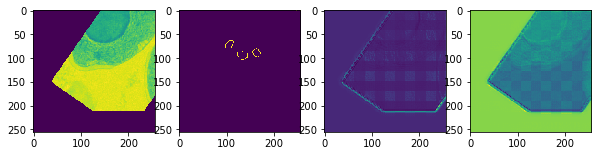

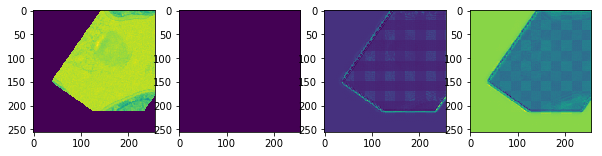

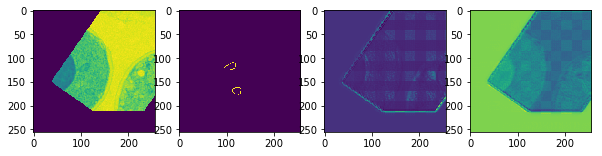

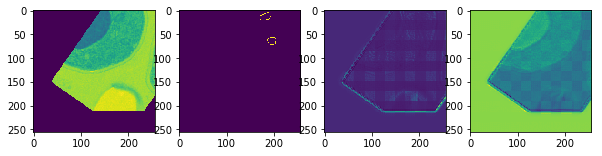

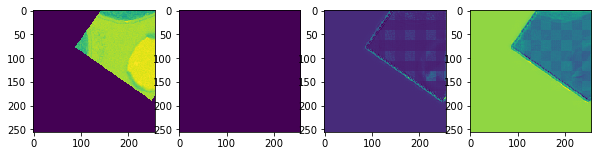

100
Training loss:  0.00574282
(20, 256, 256, 2)
Validation loss:  0.00131216


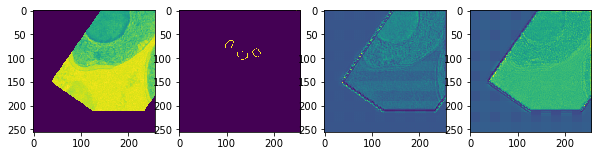

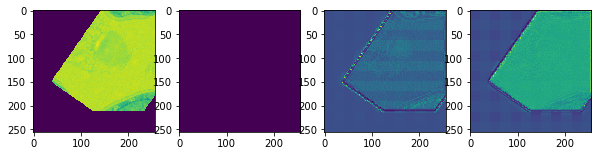

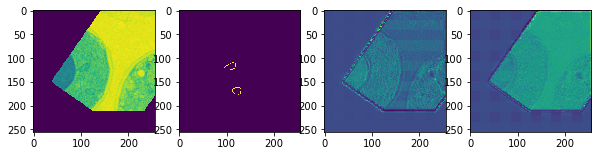

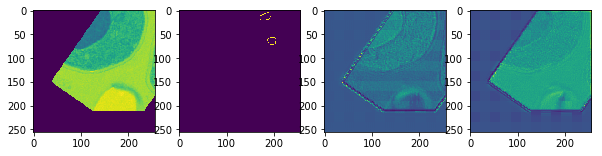

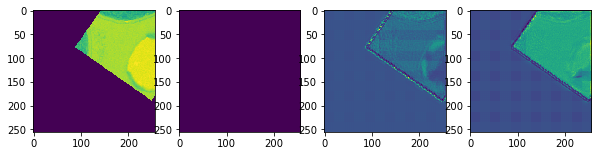

In [ ]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(max_to_keep=52)

learning_rates=[0.00003, 0.00001]
learning_rate_steps=[1000, 2400]
current_step=0
for lrate, lrs in zip(learning_rates, learning_rate_steps):
    for i in range(current_step, lrs):
        idx=np.random.choice(train_data.shape[0], replace=False, size=[50])
        cur_train=train_data[idx,:,:,:]
        cur_truth=train_truth[idx,:,:]
        _,results, losses=sess.run([train_op, probs, loss], feed_dict={x:cur_train, y:cur_truth, lr:lrate})
        if (i%100==0):
            print(i)
            print("Training loss: ",losses)
            idx=np.random.choice(validation_data.shape[0], replace=False, size=[50])
            idx=range(0,1220, 61)
            sub_validation_data=validation_data[idx, :,:,:]
            sub_validation_truth=validation_truth[idx, :,:]
            results, losses, a,c,cc=sess.run([probs, loss, A1,C2,CC2], feed_dict={x:sub_validation_data, y:sub_validation_truth})
            print(results.shape)
            print("Validation loss: ",losses)
            for ti in range (0,5):
                utils.plot_4x1(sub_validation_data[ti,:,:,0], sub_validation_truth[ti,:,:,0], results[ti,:,:,0], results[ti,:,:,1])
                plt.show()
            saver.save(sess, data+'NewModels/Model'+str(i))
    current_step=lrs

# Process new datafiles using trained network

Load the network that works best

In [8]:
saver = tf.train.Saver()


data_model=data+'NewModels/Model1000'
saver.restore(sess,data_model)

INFO:tensorflow:Restoring parameters from /home/ubuntu/NewModels/Model1000


Function for processing a file

In [7]:
def process_file(sess, file_name):
    true_test2_data=utils.get_raw_float_image(file_name, [1,256,256,3])[:,:,:,[0]]/40000.0
    true_test2_truth=utils.get_raw_float_image(file_name, [1,256,256,3])[:,:,:,[1,2]]
    true_test2_truth[:,:,:,0]=true_test2_truth[:,:,:,0]/32000.0
    true_test2_truth[:,:,:,1]=true_test2_truth[:,:,:,1]/255.0
    print(np.std(true_test2_data))
    print(np.mean(true_test2_data))
    
    #true_test2_data=true_test2_data/np.std(true_test2_data)*0.02
    #true_test2_data=true_test2_data-np.mean(true_test2_data)+0.55

    print(np.std(true_test2_data))
    print(np.mean(true_test2_data))
    
    
    num_images=true_test2_data.shape[0]
    output=np.zeros([num_images,256,256,3])
    process_batch_size=50
    print('Starting')
    for t in range(0,num_images,process_batch_size):
        endrng=np.min((t+process_batch_size,num_images))
        sub_validation_data=true_test2_data[t:(t+process_batch_size), :,:,:]
        sub_validation_truth=true_test2_truth[t:(t+process_batch_size), :,:]
        results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})
        output[t:(t+process_batch_size),:,:,0]=sub_validation_data[:,:,:,0]
        output[t:(t+process_batch_size),:,:,1]=results[:,:,:,0]
        output[t:(t+process_batch_size),:,:,2]=results[:,:,:,1]
    print('Done')
    output=np.swapaxes(np.swapaxes(output,3,2),2,1)
    np.place(output, output<0, 0)
    (output*255.0).astype(np.uint8).tofile(file_name[0:-4]+'_outputb.raw')
    print(file_name[0:-4]+'_output.raw')
    return output


In [8]:
output=process_file(sess,data+'Realv2.raw')

0.032289237
0.5301778
0.032289237
0.5301778
Starting
Done
/home/ubuntu/Data/Realv2_output.raw


In [70]:
output.shape

(11583, 3, 256, 256)